In [14]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
%matplotlib inline 
plt.style.use('ggplot')

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# Disable Python INFO and WARNING messages
warnings.filterwarnings('ignore')

In [15]:
# Import analytical base table -- represents customer-level purchase pattern features
base_df = pd.read_csv('data/analytical_base_table.csv', index_col=0)

# Import thresholded item features - represents the number of times each customer purchased each of the top 20 products
threshold_item_data = pd.read_csv('data/threshold_item_data.csv', index_col=0)

# Import PCA item features -- represents each of the 125 PCA features items by customer
pca_item_data = pd.read_csv('data/pca_item_data.csv', index_col=0)

In [16]:
# Print shape of each dataframe
print( base_df.shape )
print( threshold_item_data.shape )
print( pca_item_data.shape )

(414, 8)
(414, 20)
(414, 125)


In [17]:
# Join base_df with threshold_item_data
threshold_df = base_df.join(threshold_item_data)

# Display first 5 rows of threshold_df
threshold_df.head()

total_transactions  total_products  total_unique_products  \
CustomerID                                                              
12347                        7             182                    103   
12348                        4              31                     22   
12349                        1              73                     73   
12350                        1              17                     17   
12352                        8              85                     59   

            avg_product_value  total_sales  avg_cart_value  max_cart_value  \
CustomerID                                                                   
12347               23.681319      4310.00      615.714286         1294.32   
12348               57.975484      1797.24      449.310000          892.80   
12349               24.076027      1757.55     1757.550000         1757.55   
12350               19.670588       334.40      334.400000          334.40   
12352               29.482824      2506.04      313.255000          840.30   

            min_cart_value  22961  22630  22139  21080  85099B  20726  20719  \
CustomerID                                                                     
12347               224.82    0.0    0.0    0.0    0.0     0.0    0.0    4.0   
12348               227.44    0.0    0.0    0.0    0.0     0.0    0.0    0.0   
12349              1757.55    0.0    0.0    0.0    0.0     0.0    0.0    0.0   
12350               334.40    0.0    0.0    0.0    0.0     0.0    0.0    0.0   
12352               120.33    0.0    1.0    0.0    0.0     0.0    0.0    0.0   

            20750  23084  20725  21212  22551  22629  22328  21731  22556  \
CustomerID                                                                  
12347         0.0    3.0    0.0    0.0    0.0    0.0    0.0    5.0    0.0   
12348         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
12349         0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0   
12350         0.0    0.0    0.0    0.0    1.0    0.0    0.0    0.0    0.0   
12352         0.0    0.0    0.0    0.0    0.0    0.0    0.0    1.0    0.0   

            22554  22423  22326  POST  
CustomerID                             
12347         0.0    4.0    0.0   0.0  
12348         0.0    0.0    0.0   4.0  
12349         1.0    1.0    1.0   1.0  
12350         0.0    0.0    0.0   1.0  
12352         0.0    2.0    0.0   5.0

In [18]:
# Join base_df with pca_item_data
pca_df = base_df.join(pca_item_data)

# Display first 5 rows of pca_df
pca_df.head()

total_transactions  total_products  total_unique_products  \
CustomerID                                                              
12347                        7             182                    103   
12348                        4              31                     22   
12349                        1              73                     73   
12350                        1              17                     17   
12352                        8              85                     59   

            avg_product_value  total_sales  avg_cart_value  max_cart_value  \
CustomerID                                                                   
12347               23.681319      4310.00      615.714286         1294.32   
12348               57.975484      1797.24      449.310000          892.80   
12349               24.076027      1757.55     1757.550000         1757.55   
12350               19.670588       334.40      334.400000          334.40   
12352               29.482824      2506.04      313.255000          840.30   

            min_cart_value       PC1       PC2       PC3       PC4       PC5  \
CustomerID                                                                     
12347               224.82  5.876141  4.828915 -0.495529  3.093863 -0.633761   
12348               227.44 -4.219838  1.226191 -1.881920 -0.174504  0.817972   
12349              1757.55 -1.260860  2.387672 -0.072842 -1.119334 -0.034739   
12350               334.40 -4.929319 -0.714921 -1.581035 -0.469757 -0.116431   
12352               120.33 -2.053123  2.110983  0.184916  0.128554  0.087858   

                  PC6       PC7       PC8       PC9      PC10      PC11  \
CustomerID                                                                
12347      -11.534120  2.162029  7.116958  5.336096  4.424375  4.637000   
12348        1.160861 -0.871566 -0.846596  0.460044  0.854401 -0.401956   
12349       -3.715426 -0.343282 -0.148452 -0.788739 -0.378746  1.569785   
12350        0.647778  0.112973 -1.336466  1.546880 -1.190963 -0.212920   
12352       -1.943971  2.383041  0.899607 -0.672495  0.083157  0.877834   

                PC12       PC13      PC14       PC15      PC16      PC17  \
CustomerID                                                                 
12347       2.316456  12.310762  1.986719 -11.431133  5.617793 -2.177430   
12348       0.981705  -1.104823  0.770037  -0.092621 -0.313433 -0.448318   
12349       0.183646   0.223992 -0.051240   3.179430 -0.513274 -1.842703   
12350       1.057154  -0.474704  0.856426  -1.304989  0.243234  0.268690   
12352       1.051716  -0.741849 -2.071099  -0.638169  0.019544  0.117731   

                PC18       PC19       PC20      PC21      PC22       PC23  \
CustomerID                                                                  
12347       7.665696 -12.135623 -16.049596 -5.949100  7.814388  40.519372   
12348       1.206871   0.382305  -0.470012  0.187541  0.053925   0.499538   
12349       0.385045   0.317433  -0.000912 -0.422785  0.457948  -0.790996   
12350       1.953071  -0.226744   0.570463 -0.187166  0.903625   1.364871   
12352       0.573086  -0.029574   0.111118 -0.693001 -0.914322  -2.336441   

                 PC24       PC25      PC26       PC27      PC28       PC29  \
CustomerID                                                                   
12347      -35.574631 -17.557644  6.867379  20.886063  2.296301 -26.160958   
12348        0.372329   1.226211 -0.774129  -0.270101  0.849801  -0.370324   
12349        1.750581  -1.483614  0.760903  -0.911680  0.768758   0.503989   
12350        0.177854  -0.263187 -0.169386  -0.683152  1.080853  -0.155632   
12352        0.507206  -1.755869  0.219756  -1.058250 -1.804054  -0.921242   

                 PC30      PC31       PC32      PC33       PC34      PC35  \
CustomerID                                                                  
12347      -32.579890  7.876314  12.361085  6.822162 -32.956159 -4.411140   
12348       -0.

## 1. Model evaluation

#### On the Base DF 

In [19]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))

# Fit K-Means pipeline
k_means.fit(base_df)

# Save clusters to base_df
base_df['cluster'] = k_means.predict(base_df)

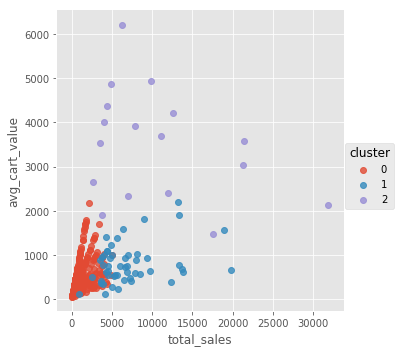

In [20]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=base_df, fit_reg=False)
plt.savefig('assets/base-cluster.png')

#### On the Threshold DF

In [24]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))

# Fit K-Means pipeline
k_means.fit(threshold_df)

# Save clusters to threshold_df
threshold_df['cluster'] = k_means.predict(threshold_df)

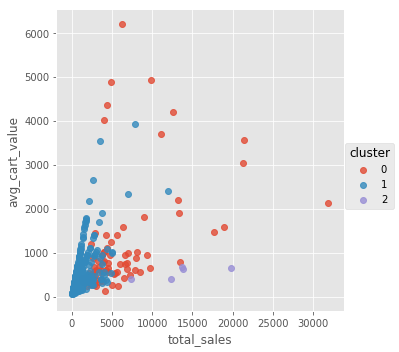

In [25]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=threshold_df, fit_reg=False)

#### On the PCA DF

In [26]:
# K-Means model pipeline
k_means = make_pipeline(StandardScaler(), KMeans(n_clusters=3, random_state=123))

# Fit K-Means pipeline
k_means.fit(pca_df)

# Save clusters to pca_df
pca_df['cluster'] = k_means.predict(pca_df)

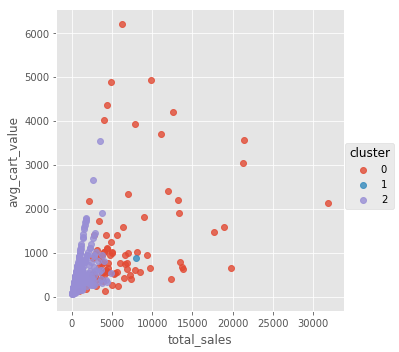

In [27]:
# Scatterplot, colored by cluster
sns.lmplot(x='total_sales', y='avg_cart_value', hue='cluster', data=pca_df, fit_reg=False)

## 2. Model comparison 

In [28]:
# Similary between base_df.cluster and threshold_df.cluster
adjusted_rand_score(base_df.cluster, threshold_df.cluster)

0.60213549517823428

In [29]:
# Similary between base_df.cluster and pca_df.cluster
adjusted_rand_score(base_df.cluster, pca_df.cluster)

0.73735014175667257

In [ ]:
Based on the metrics, the model based on data with the principal components features seems to be the most similar to the analytical base dataset.